In [1]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score

In [2]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [45]:
my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

# Model based clustering

## Gaussian Mixture

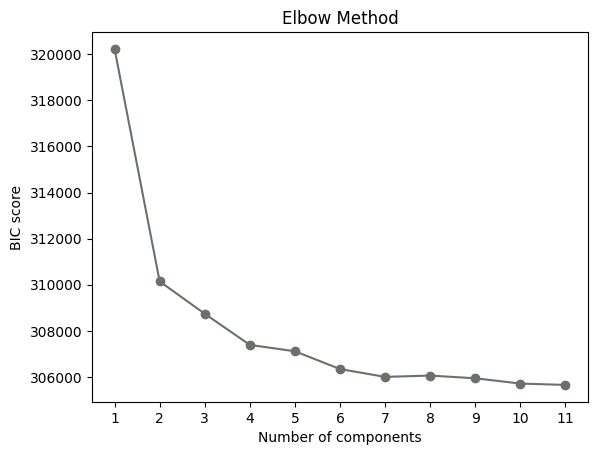

In [11]:
n_components_range = range(1, 12)
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    bic_scores.append(gmm.bic(pca_df))

# Plot the BIC scores against the number of components
plt.plot(n_components_range, bic_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.title('Elbow Method')
plt.xticks(n_components_range)
plt.show()

BIC (Bayesian Information Criterion) is given by the formula: BIC = -2 * loglikelihood + d * log(N), where N is the sample size of the training set and d is the total number of parameters. The lower BIC score signals a better model.

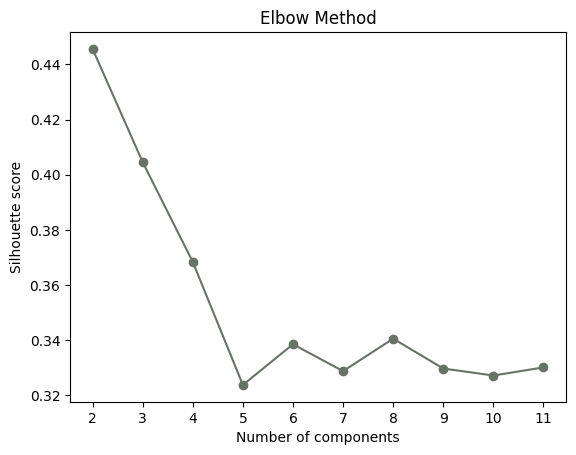

In [12]:
n_components_range = range(2, 12)  
silhouette_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    labels = gmm.predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, labels))

plt.plot(n_components_range, silhouette_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('Silhouette score')
plt.title('Elbow Method')
plt.xticks(n_components_range)
plt.show()


so, 8 clusters as is where the BIC assumes a low value and starts decreasing more slowly and is where the silhouette index also starts decreasing but still has a not so low value

In [13]:
gaussian_mix = GaussianMixture(n_components=8, random_state=42, verbose=1)
gaussian_mix.fit(pca_df)

Initialization 0
Initialization converged: True


GaussianMixture(n_components=8, random_state=42, verbose=1)

In [14]:
with open('results/model_based/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [38]:
with open('results/model_based/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [15]:
labels = gaussian_mix.predict(pca_df)

In [16]:
len(np.unique(labels))

8

In [19]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']

In [20]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_subset['cluster_label'] = labels

In [21]:
df_subset.to_csv('results/model_based/csv_labels_cut_raw/gaussian_mix.csv', index = False)

In [22]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.loc[:,:'farm']

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,1


In [23]:
len(most_frequent_clusters.unique())

5

In [24]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,1
1,-0.374977,-1.197599,11,1
2,1.976068,-0.386187,11,1
3,-1.228114,-1.370854,11,1
4,1.454437,-1.465956,11,1


In [25]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,1
1,12,-3.048094,0.908466,0
2,13,-2.296033,-0.692692,0
3,14,4.322358,0.855529,1
4,15,-3.222389,1.460962,2
...,...,...,...,...
66,414,-1.996917,-1.151260,7
67,415,-0.195303,-1.531435,7
68,510,-1.418674,0.145497,1
69,511,1.187020,0.759987,1


In [26]:
pca_df = pca_df.drop(columns='asset_id')

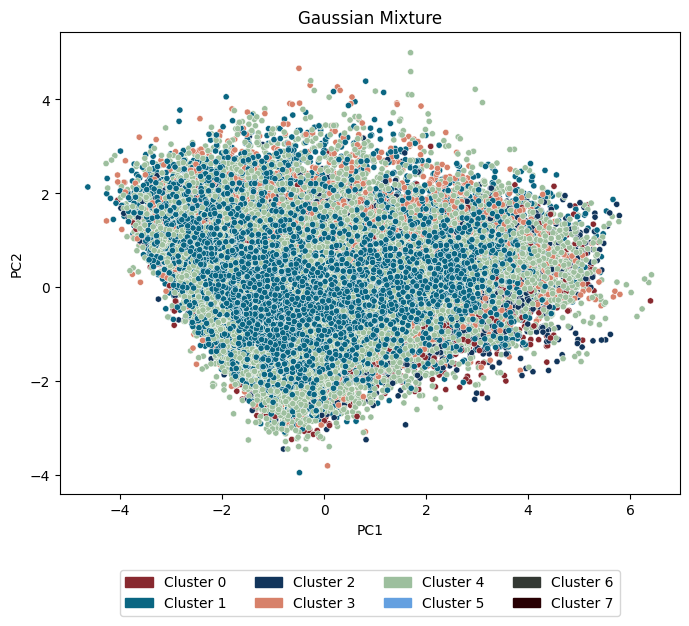

In [42]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [43]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 2, 5, 8, 52]
Cluster 1: [0, 3, 9, 14, 20, 24, 28, 29, 30, 31, 33, 37, 39, 41, 42, 44, 62, 63, 65, 68, 69, 70]
Cluster 2: [4, 6, 7, 45, 50, 51]
Cluster 6: [10, 11, 12, 13, 15, 16, 17, 36, 38, 40, 43, 53, 55, 56]
Cluster 7: [18, 19, 21, 22, 23, 25, 26, 27, 32, 34, 35, 46, 47, 48, 49, 54, 57, 58, 59, 60, 61, 64, 66, 67]


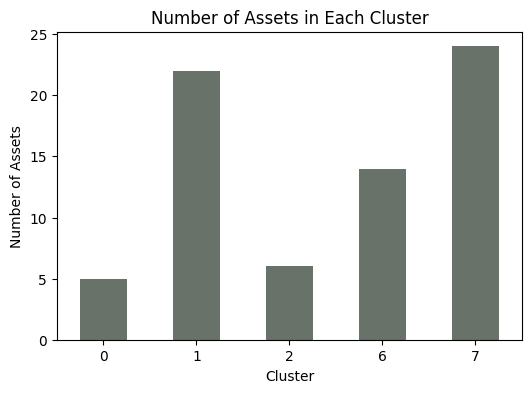

In [46]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors_2[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [47]:
df_subset.to_csv('results/model_based/labels_most_common/gaussian_mix.csv', index= False)

In [48]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']